# **Group Members:**
Rida Amir (21L-5184)
Haisem Naeem (21L-7528)
Hamza Amer (21L-5368)

# **Dataset Description and Features**

# Dataset Identification

The dataset we have choosen is taken from kaggle:

> https://www.kaggle.com/datasets/gowrishankarp/newspaper-text-summarization-cnn-dailymail?resource=download

Our aim to develop a text summarizer with will take the highlights of an article and generate its highlights

# Features

The initial dataset contains article, which will be used as source text and hightlights, which will be our target or summarized text and an id for each entry which plays no role in summarization of we will eliminate it.


# **Preprocessing with Pandas**

# Import libraries

In [ ]:
!pip install kaggle
import torch
from transformers import BartTokenizer, BartForConditionalGeneration
from torch.utils.data import Dataset, DataLoader
from google.colab import files
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
!pip install rouge-score
from rouge_score import rouge_scorer
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Loading Dataset

In [ ]:
files.upload()

!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

!kaggle datasets download -d gowrishankarp/newspaper-text-summarization-cnn-dailymail
!unzip newspaper-text-summarization-cnn-dailymail.zip

training_dataset = pd.read_csv("cnn_dailymail/train.csv")
test_dataset=pd.read_csv("cnn_dailymail/test.csv")
training_dataset

,id,article,highlights
0,0001d1afc246a7964130f43ae940af6bc6c57f01,By . Associated Press . PUBLISHED: . 14:11 EST...,"Bishop John Folda, of North Dakota, is taking ..."
1,0002095e55fcbd3a2f366d9bf92a95433dc305ef,(CNN) -- Ralph Mata was an internal affairs li...,Criminal complaint: Cop used his role to help ...
2,00027e965c8264c35cc1bc55556db388da82b07f,A drunk driver who killed a young woman in a h...,"Craig Eccleston-Todd, 27, had drunk at least t..."
3,0002c17436637c4fe1837c935c04de47adb18e9a,(CNN) -- With a breezy sweep of his pen Presid...,Nina dos Santos says Europe must be ready to a...
4,0003ad6ef0c37534f80b55b4235108024b407f0b,Fleetwood are the only team still to have a 10...,Fleetwood top of League One after 2-0 win at S...
...,...,...,...
287108,fffdfb56fdf1a12d364562cc2b9b1d4de7481dee,By . James Rush . Former first daughter Chelse...,Chelsea Clinton said question of running for o...
287109,fffeecb8690b85de8c3faed80adbc7a978f9ae2a,An apologetic Vanilla Ice has given his first ...,"Vanilla Ice, 47 - real name Robert Van Winkle ..."
287110,ffff5231e4c71544bc6c97015cdb16c60e42b3f4,America's most lethal sniper claimed he wished...,America's most lethal sniper made comment in i...
287111,ffff924b14a8d82058b6c1c5368ff1113c1632af,"By . Sara Malm . PUBLISHED: . 12:19 EST, 8 Mar...",A swarm of more than one million has crossed b...


# Missing values

In [ ]:
training_dataset = training_dataset.rename(columns={"highlights":"target_text", "article":"source_text"})
training_dataset = training_dataset[['source_text', 'target_text']]

test_dataset = test_dataset.rename(columns={"highlights":"target_text", "article":"source_text"})
test_dataset = test_dataset[['source_text', 'target_text']]

def count_words(text):
    return len(text.split())

training_dataset['source_text_length'] = training_dataset['source_text'].apply(lambda x: count_words(x))
training_dataset['target_text_length'] = training_dataset['target_text'].apply(lambda x: count_words(x))
training_dataset['word_frequency']=training_dataset['source_text_length']/training_dataset['target_text_length']

test_dataset['source_text_length'] = test_dataset['source_text'].apply(lambda x: count_words(x))
test_dataset['target_text_length'] = test_dataset['target_text'].apply(lambda x: count_words(x))
test_dataset['word_frequency']=test_dataset['source_text_length']/test_dataset['target_text_length']

In [ ]:
training_dataset.head()

,source_text,target_text,source_text_length,target_text_length,word_frequency
0,By . Associated Press . PUBLISHED: . 14:11 EST...,"Bishop John Folda, of North Dakota, is taking ...",198,37,5.351351
1,(CNN) -- Ralph Mata was an internal affairs li...,Criminal complaint: Cop used his role to help ...,392,38,10.315789
2,A drunk driver who killed a young woman in a h...,"Craig Eccleston-Todd, 27, had drunk at least t...",808,69,11.710145
3,(CNN) -- With a breezy sweep of his pen Presid...,Nina dos Santos says Europe must be ready to a...,531,53,10.018868
4,Fleetwood are the only team still to have a 10...,Fleetwood top of League One after 2-0 win at S...,580,67,8.656716


# Outliers


In [ ]:
print("Training Dataset Shape before removing outliers:",training_dataset.shape)
Q1 = training_dataset['word_frequency'].quantile(0.25)
Q3 = training_dataset['word_frequency'].quantile(0.75)
IQR = Q3 - Q1

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

training_dataset = training_dataset[(training_dataset['word_frequency'] >= lower_bound) & (training_dataset['word_frequency'] <= upper_bound)]
print("Training Dataset Shape before removing outliers:",training_dataset.shape)

print("Test Dataset Shape before removing outliers:",test_dataset.shape)
Q1 = test_dataset['word_frequency'].quantile(0.25)
Q3 = test_dataset['word_frequency'].quantile(0.75)
IQR = Q3 - Q1

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

test_dataset = test_dataset[(test_dataset['word_frequency'] >= lower_bound) & (test_dataset['word_frequency'] <= upper_bound)]
print("Test Dataset Shape before removing outliers:",test_dataset.shape)

Training Dataset Shape before removing outliers: (287113, 5)
Training Dataset Shape before removing outliers: (275190, 5)
Test Dataset Shape before removing outliers: (11490, 5)
Test Dataset Shape before removing outliers: (11025, 5)


# Data Type Conversion

No Datatype conversion is needed

# Dimensionality

In [ ]:
print("Traing Dataset Shape: ",training_dataset.shape)
print("Test Dataset Shape: ",test_dataset.shape)

Traing Dataset Shape:  (275190, 5)
Test Dataset Shape:  (11025, 5)


# Descriptive Statistics

In [ ]:
training_dataset.describe()

,source_text_length,target_text_length,word_frequency
count,275190.000000,275190.000000,275190.000000
mean,671.755344,52.570944,13.564517
std,319.379062,21.019085,6.311799
min,8.000000,7.000000,0.052632
25%,435.000000,39.000000,8.714286
50%,619.000000,49.000000,12.413043
75%,851.000000,61.000000,17.354009
max,2226.000000,1296.000000,32.317073


# **Preprocessing with Pandas**

# Numerical Features

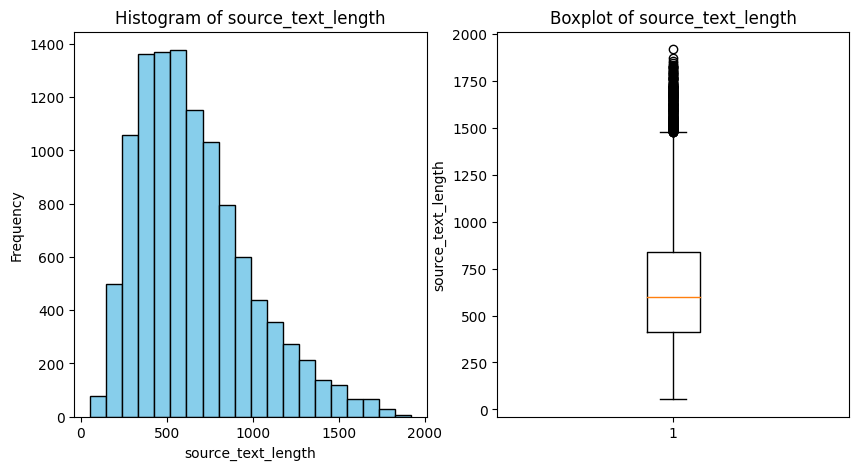

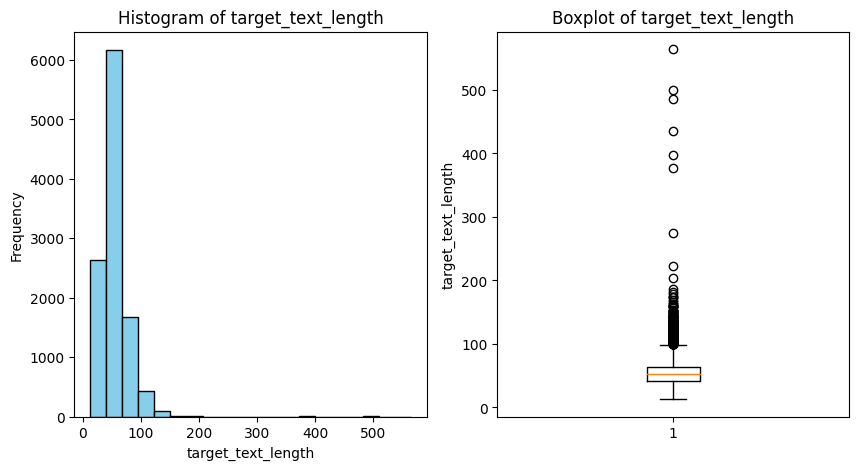

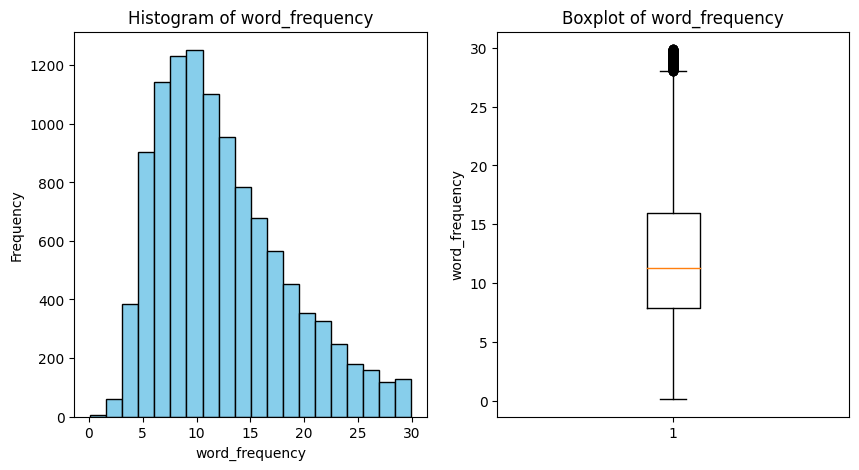

In [ ]:
# Extract numerical features from the dataset
numerical_features = test_dataset.select_dtypes(include=['int', 'float'])

# Visualize the distribution of numerical features
for column in numerical_features.columns:
    # Create a figure with subplots for histogram and boxplot
    fig, axes = plt.subplots(1, 2, figsize=(10, 5))

    # Histogram
    axes[0].hist(test_dataset[column], bins=20, color='skyblue', edgecolor='black')
    axes[0].set_title(f'Histogram of {column}')
    axes[0].set_xlabel(column)
    axes[0].set_ylabel('Frequency')

    # Boxplot
    axes[1].boxplot(test_dataset[column])
    axes[1].set_title(f'Boxplot of {column}')
    axes[1].set_ylabel(column)

    # Show the plots
    plt.show()

There are outliers as a lot of the values are above the maximum range. The histogram is skewed towards the left side meaning the dataset includes more of low text length words

# Categorical Features

Our dataset has no categorical features

# Scatter Plots

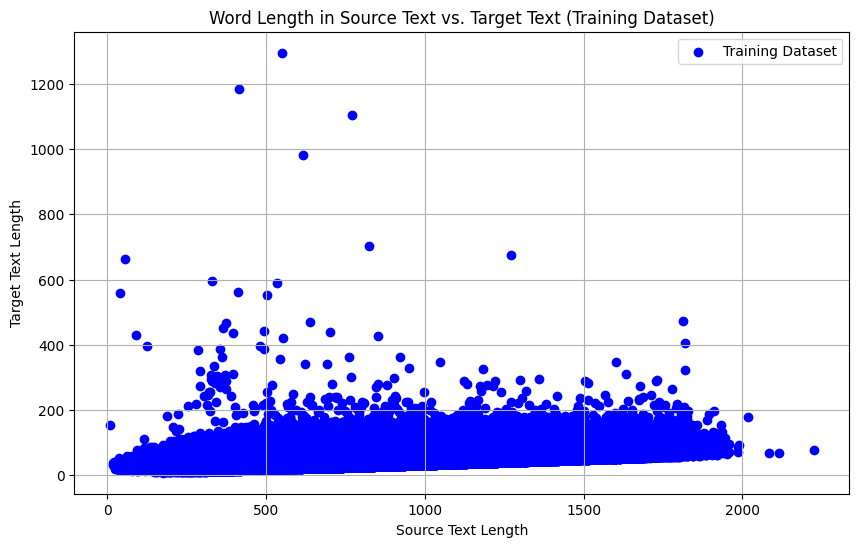

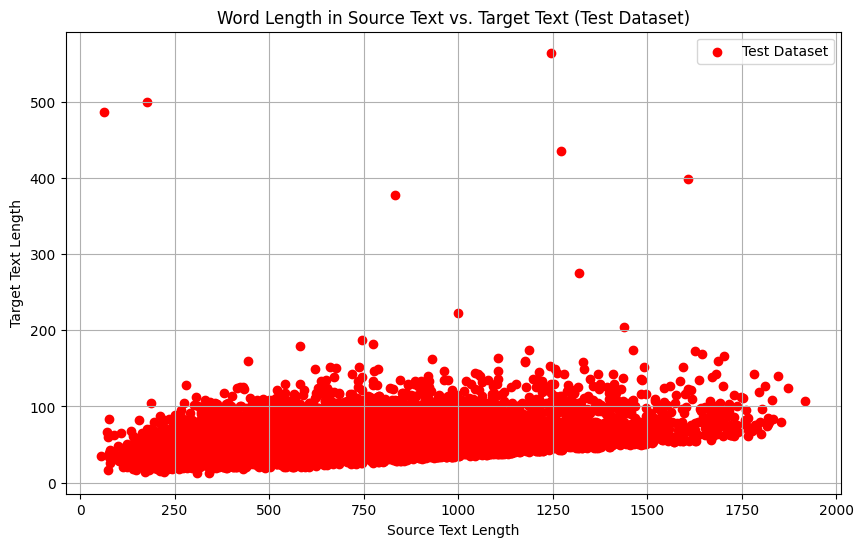

In [ ]:
# Scatter plot for training dataset
plt.figure(figsize=(10, 6))
plt.scatter(training_dataset['source_text_length'], training_dataset['target_text_length'], color='blue', label='Training Dataset')
plt.title('Word Length in Source Text vs. Target Text (Training Dataset)')
plt.xlabel('Source Text Length')
plt.ylabel('Target Text Length')
plt.legend()
plt.grid(True)
plt.show()

# Scatter plot for test dataset
plt.figure(figsize=(10, 6))
plt.scatter(test_dataset['source_text_length'], test_dataset['target_text_length'], color='red', label='Test Dataset')
plt.title('Word Length in Source Text vs. Target Text (Test Dataset)')
plt.xlabel('Source Text Length')
plt.ylabel('Target Text Length')
plt.legend()
plt.grid(True)
plt.show()


It has a linear trend similar in both graphs with a strong correlation at smaller values of target text length

# Pair Plots

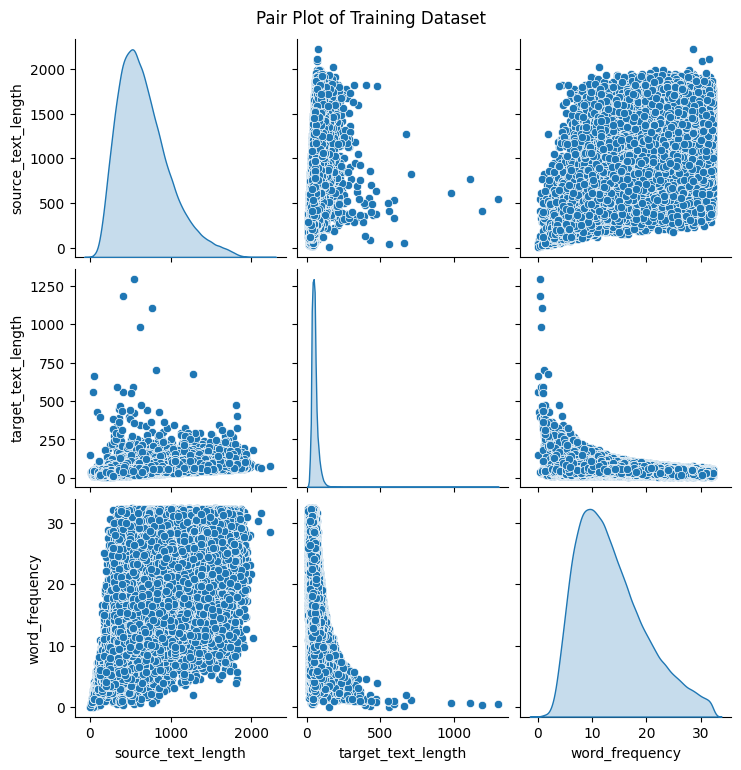

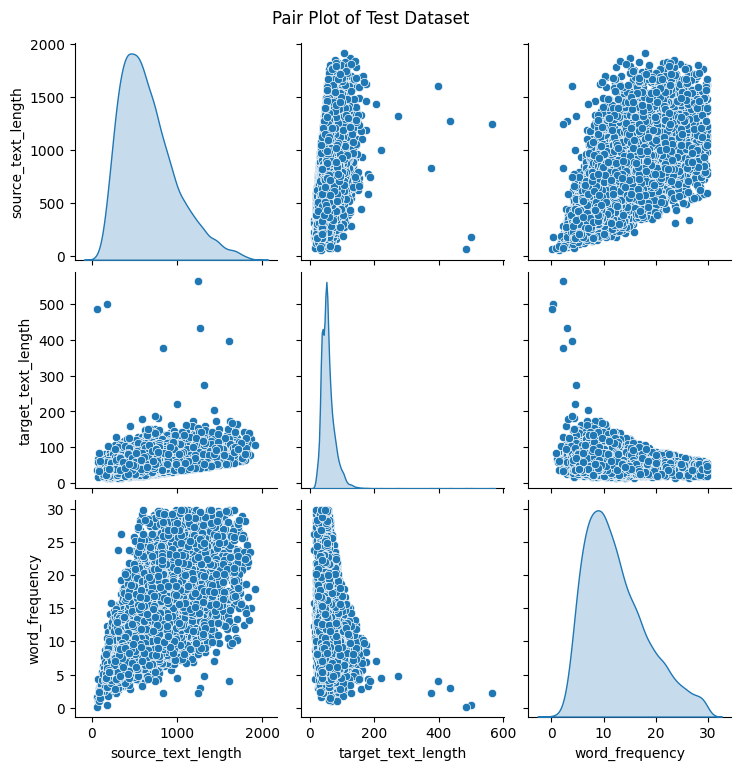

In [ ]:
# Pair plot for training dataset
sns.pairplot(training_dataset[['source_text_length', 'target_text_length', 'word_frequency']], diag_kind='kde')
plt.suptitle('Pair Plot of Training Dataset', y=1.02)
plt.show()

# Pair plot for test dataset
sns.pairplot(test_dataset[['source_text_length', 'target_text_length', 'word_frequency']], diag_kind='kde')
plt.suptitle('Pair Plot of Test Dataset', y=1.02)
plt.show()

# **Methodology**

Since the project involves text summarization, we have opted to utilize the BART (Bidirectional and Auto-Regressive Transformers) model, known for its strong performance in sequence-to-sequence tasks. This model is specifically tailored for tasks like text summarization, thanks to its architecture that incorporates both bidirectional and auto-regressive components.

We leveraged from the Transformers library, developed by Hugging Face, which offers a comprehensive suite of pre-trained transformer models and tools for natural language processing tasks. Specifically, we will use the BART model architecture along with the BART tokenizer, which efficiently handles tokenization and conversion of input text into suitable format for the model.

# **Machine Learning Model Implementation**

In [ ]:
class MyDataset(Dataset):
    def __init__(self, data, tokenizer, max_source_length=512, max_target_length=150):
        self.data = data
        self.tokenizer = tokenizer
        self.max_source_length = max_source_length
        self.max_target_length = max_target_length

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        source_text = self.data.iloc[idx]['source_text']
        target_text = self.data.iloc[idx]['target_text']

        source_tokens = self.tokenizer.encode_plus(
            source_text,
            max_length=self.max_source_length,
            padding="max_length",
            truncation=True,
            return_tensors="pt"
        )
        target_tokens = self.tokenizer.encode(
            target_text,
            max_length=self.max_target_length,
            padding="max_length",
            truncation=True,
            return_tensors="pt"
        )

        return {
            "input_ids": source_tokens["input_ids"].flatten(),
            "attention_mask": source_tokens["attention_mask"].flatten(),
            "labels": target_tokens.flatten()
        }

In [ ]:
tokenizer = BartTokenizer.from_pretrained("facebook/bart-large-cnn")
model = BartForConditionalGeneration.from_pretrained("facebook/bart-large-cnn")

train_dataset = MyDataset(training_dataset, tokenizer)
train_loader = DataLoader(train_dataset, batch_size=1, shuffle=True)

In [ ]:
# Define training parameters
optimizer = torch.optim.AdamW(model.parameters(), lr=5e-5)
num_epochs = 100

accumulation_steps = 12

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for i, batch in enumerate(train_loader):
        optimizer.zero_grad()
        input_ids = batch["input_ids"]
        attention_mask = batch["attention_mask"]
        labels = batch["labels"]
        outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        loss = loss / accumulation_steps
        loss.backward()
        running_loss += loss.item()

        if (i + 1) % accumulation_steps == 0:
            optimizer.step()
            optimizer.zero_grad()
            running_loss = 0.0


In [ ]:
model.save_pretrained("/content/custom_bart_model")
tokenizer.save_pretrained("/content/custom_bart_model")

Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-default generation parameters: {'max_length': 142, 'min_length': 56, 'early_stopping': True, 'num_beams': 4, 'length_penalty': 2.0, 'no_repeat_ngram_size': 3, 'forced_bos_token_id': 0, 'forced_eos_token_id': 2}


('/content/custom_bart_model/tokenizer_config.json',
 '/content/custom_bart_model/special_tokens_map.json',
 '/content/custom_bart_model/vocab.json',
 '/content/custom_bart_model/merges.txt',
 '/content/custom_bart_model/added_tokens.json')

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
def predict(text):
  inputs = tokenizer(text, return_tensors="pt", max_length=512, truncation=True, padding=True)
  summary_ids = model.generate(inputs['input_ids'], max_length=150, num_beams=4, early_stopping=True)
  summary = tokenizer.decode(summary_ids[0], skip_special_tokens=True)
  return summary

# **Model Evaluation**

# Rouge

In [ ]:
scorer = rouge_scorer.RougeScorer(["rouge1", "rouge2", "rougeL"])
rouge_scores = []

for text, summary in zip(test_dataset["source_text"], test_dataset["target_text"]):
    predicted_summary = predict(text)

    predicted_summary = " ".join(predicted_summary)

    scores = scorer.score(summary, predicted_summary)
    rouge_scores.append(scores)

**Precision**

In [ ]:
average_precision = {
    "rouge1": sum(score['rouge1'].precision for score in rouge_scores) / len(rouge_scores),
    "rouge2": sum(score['rouge2'].precision for score in rouge_scores) / len(rouge_scores),
    "rougeL": sum(score['rougeL'].precision for score in rouge_scores) / len(rouge_scores)
}

print("Average precision:", average_precision)

Average precision: {'rouge1': 0.006097560975609756, 'rouge2': 0.0030581039755351682, 'rougeL': 0.006097560975609756}


**Recall**

In [ ]:
average_recall = {
    "rouge1": sum(score['rouge1'].recall for score in rouge_scores) / len(rouge_scores),
    "rouge2": sum(score['rouge2'].recall for score in rouge_scores) / len(rouge_scores),
    "rougeL": sum(score['rougeL'].recall for score in rouge_scores) / len(rouge_scores)
}

print("Average recall:", average_recall)

Average recall: {'rouge1': 0.058823529411764705, 'rouge2': 0.030303030303030304, 'rougeL': 0.058823529411764705}


**fmeasure**

In [ ]:
average_fmeasure = {
    "rouge1": sum(score['rouge1'].fmeasure for score in rouge_scores) / len(rouge_scores),
    "rouge2": sum(score['rouge2'].fmeasure for score in rouge_scores) / len(rouge_scores),
    "rougeL": sum(score['rougeL'].fmeasure for score in rouge_scores) / len(rouge_scores)
}

print("Average fmeasure:", average_fmeasure)

Average fmeasure: {'rouge1': 0.011049723756906077, 'rouge2': 0.005555555555555556, 'rougeL': 0.011049723756906077}


# Evaluating Word Frequency

In [ ]:
true_labels = []
predicted_labels = []

def count_words(text):
  return len(text.split())

for text, summary,frequency in zip(test_dataset["source_text"].iloc[:2], test_dataset["target_text"].iloc[:2],test_dataset["word_frequency"].iloc[:2]):
    predicted_summary = predict(text)

    predicted_summary = " ".join(predicted_summary)

    word_frequency=count_words(text)/count_words(predicted_summary)

    true_labels.append(frequency)
    predicted_labels.append(word_frequency)

**Mean Absolute Error (MAE)**

In [ ]:
mae = mean_absolute_error(true_labels, predicted_labels)
print("Mean Absolute Error (MAE):", mae)

Mean Absolute Error (MAE): 8.070732092677583


**Mean Squared Error (MSE)**

In [ ]:
mse = mean_squared_error(true_labels, predicted_labels)
print("Mean Squared Error (MSE):", mse)

Mean Squared Error (MSE): 66.47284287122284


**R2 Score**

In [ ]:
r2 = r2_score(true_labels, predicted_labels)
print("R2 Score:", r2)

R2 Score: -59.66391181290926
